In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import multitask_dep as mt
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [7]:
convai_train_dataset =rrnn.DatasetMultiTaskRRNN(convai_train_token,tasks,eval=False,deps=True)

In [8]:
convai_val_dataset = rrnn.DatasetMultiTaskRRNN(convai_val_token,tasks,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskRRNN(md_tokenized,tasks,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep_multi)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep_multi)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep_multi)

# Pruebas hiperparámetros 1

In [12]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

In [13]:
num_epochs = 100
learning_rate = 5e-5

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0752399474486243 	 Validation loss: 2.0780053704471912 	 
  1%|          | 574/57400 [00:07<11:26, 82.75it/s]
Epoch 2 	 Training loss: 2.073154542088924 	 Validation loss: 2.080677666906583 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:14<10:24, 90.02it/s]
Epoch 3 	 Training loss: 2.0689585113359246 	 Validation loss: 2.0716971462055787 	 
  3%|▎         | 1722/57400 [00:22<14:00, 66.23it/s]
Epoch 4 	 Training loss: 2.06625111883941 	 Validation loss: 2.0722405142703297 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:30<10:41, 85.91it/s]
Epoch 5 	 Training loss: 2.0644006081159105 	 Validation loss: 2.06834781371941 	 
  5%|▌         | 2870/57400 [00:37<10:11, 89.16it/s]
Epoch 6 	 Training loss: 2.0630659674933565 	 Validation loss: 2.0688563888355835 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:44<10:16, 87.59it/s]
Epoch 7 	 Training loss: 2.06123395913154 	 Validation loss: 2.069337695331897 	 

2 epoch w

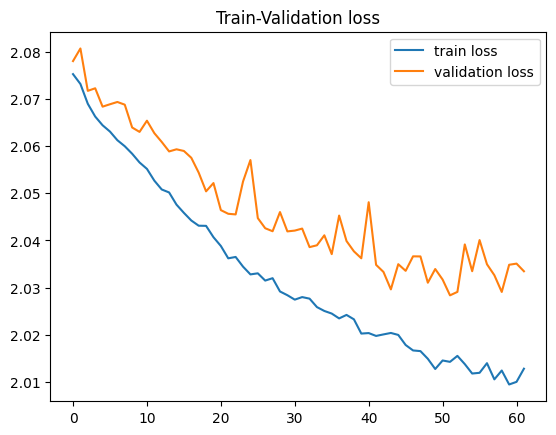

In [14]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_multi_{encoding_type}_v1_1'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5656565656565656, 'precision': 0.5656565656565656, 'f1': 0.5656565656565656, 'accuracy': 0.5656565656565656}, 'as': {'recall': 0.5867014341590613, 'precision': 0.5867014341590613, 'f1': 0.5867014341590613, 'accuracy': 0.5867014341590613}, 'about': {'recall': 0.6186224489795918, 'precision': 0.6186224489795918, 'f1': 0.6186224489795918, 'accuracy': 0.6186224489795918}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7664233576642335, 'precision': 0.7664233576642335, 'f1': 0.7664233576642334, 'accuracy': 0.7664233576642335}, 'as': {'recall': 0.7626262626262627, 'precision': 0.7626262626262627, 'f1': 0.7626262626262628, 'accuracy': 0.7626262626262627}, 'about': {'recall': 0.8307291666666666, 'precision': 0.8307291666666666, 'f1': 0.8307291666666666, 'accuracy': 0.8307291666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.34908136482939633, 'precision': 0.34908136482939633, 'f1': 0.34908136482939633, 'accuracy': 0.34908136482939633}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0757325248020453 	 Validation loss: 2.0792450177467474 	 
  1%|          | 574/57400 [00:07<20:56, 45.22it/s]
Epoch 2 	 Training loss: 2.0731013157641844 	 Validation loss: 2.0766863055148366 	 
  2%|▏         | 1148/57400 [00:14<10:54, 85.94it/s]
Epoch 3 	 Training loss: 2.0682282871485587 	 Validation loss: 2.0714045379121426 	 
  3%|▎         | 1722/57400 [00:21<10:31, 88.23it/s]
Epoch 4 	 Training loss: 2.0645590891821457 	 Validation loss: 2.0726513741380077 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:28<10:25, 88.08it/s]
Epoch 5 	 Training loss: 2.062732695287113 	 Validation loss: 2.0718675669977222 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:35<10:18, 88.11it/s]
Epoch 6 	 Training loss: 2.0601019900850304 	 Validation loss: 2.0668591725624212 	 
  6%|▌         | 3444/57400 [00:42<10:15, 87.67it/s]
Epoch 7 	 Training loss: 2.0584843657157976 	 Validation loss: 2.0703311815100203 	 

1 epoch without improvement
  

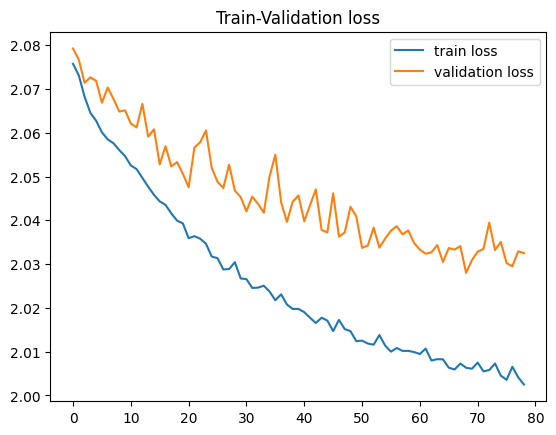

In [16]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

save_path=f'm1_rrnn_multi_{encoding_type}_v1_2'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5795454545454546, 'precision': 0.5795454545454546, 'f1': 0.5795454545454546, 'accuracy': 0.5795454545454546}, 'as': {'recall': 0.6101694915254238, 'precision': 0.6101694915254238, 'f1': 0.6101694915254238, 'accuracy': 0.6101694915254238}, 'about': {'recall': 0.6747448979591837, 'precision': 0.6747448979591837, 'f1': 0.6747448979591837, 'accuracy': 0.6747448979591837}} 

Evaluación en etiquetas male
{'to': {'recall': 0.683698296836983, 'precision': 0.683698296836983, 'f1': 0.683698296836983, 'accuracy': 0.683698296836983}, 'as': {'recall': 0.6944444444444444, 'precision': 0.6944444444444444, 'f1': 0.6944444444444444, 'accuracy': 0.6944444444444444}, 'about': {'recall': 0.7838541666666666, 'precision': 0.7838541666666666, 'f1': 0.7838541666666666, 'accuracy': 0.7838541666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.4671916010498688, 'precision': 0.4671916010498688, 'f1': 0.4671916010498688, 'accuracy': 0.4671916010498688}, 'as': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075597336483334 	 Validation loss: 2.0839002657744845 	 
  1%|          | 574/57400 [00:07<10:50, 87.38it/s]
Epoch 2 	 Training loss: 2.071868739477018 	 Validation loss: 2.071031962410878 	 
  2%|▏         | 1148/57400 [00:14<10:42, 87.62it/s]
Epoch 3 	 Training loss: 2.066147304993473 	 Validation loss: 2.0717874381501797 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:21<10:37, 87.35it/s]
Epoch 4 	 Training loss: 2.06471074001299 	 Validation loss: 2.0658210819050415 	 
  4%|▍         | 2296/57400 [00:28<10:27, 87.77it/s]
Epoch 5 	 Training loss: 2.062294989928136 	 Validation loss: 2.0654018491001453 	 
  5%|▌         | 2870/57400 [00:35<10:22, 87.56it/s]
Epoch 6 	 Training loss: 2.059693460265103 	 Validation loss: 2.06635302608296 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:42<10:12, 88.12it/s]
Epoch 7 	 Training loss: 2.0584345183721404 	 Validation loss: 2.06571116285809 	 

2 epoch without improvement
  7%|▋       

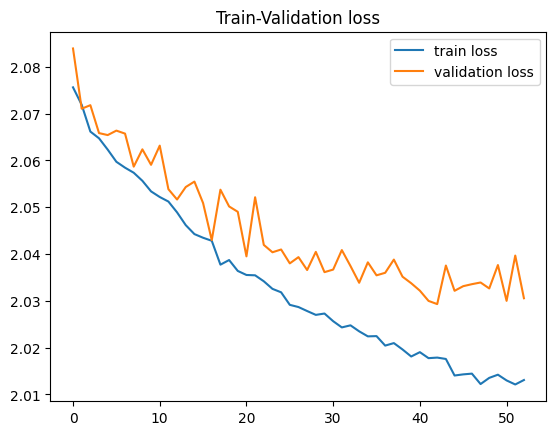

In [18]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

save_path=f'm1_rrnn_multi_{encoding_type}_v1_3'
optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Evaluación del modelo
{'to': {'recall': 0.5454545454545454, 'precision': 0.5454545454545454, 'f1': 0.5454545454545454, 'accuracy': 0.5454545454545454}, 'as': {'recall': 0.6153846153846154, 'precision': 0.6153846153846154, 'f1': 0.6153846153846154, 'accuracy': 0.6153846153846154}, 'about': {'recall': 0.639030612244898, 'precision': 0.639030612244898, 'f1': 0.639030612244898, 'accuracy': 0.639030612244898}} 

Evaluación en etiquetas male
{'to': {'recall': 0.5912408759124088, 'precision': 0.5912408759124088, 'f1': 0.5912408759124088, 'accuracy': 0.5912408759124088}, 'as': {'recall': 0.6363636363636364, 'precision': 0.6363636363636364, 'f1': 0.6363636363636364, 'accuracy': 0.6363636363636364}, 'about': {'recall': 0.7135416666666666, 'precision': 0.7135416666666666, 'f1': 0.7135416666666666, 'accuracy': 0.7135416666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.49606299212598426, 'precision': 0.49606299212598426, 'f1': 0.49606299212598426, 'accuracy': 0.49606299212598426}, 'a

In [20]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6441326530612245, 'precision': 0.6441326530612245, 'f1': 0.6441326530612245, 'accuracy': 0.6441326530612245}
Métricas etiqueta male: {'recall': 0.7760416666666666, 'precision': 0.7760416666666666, 'f1': 0.7760416666666666, 'accuracy': 0.7760416666666666}
Métricas etiqueta female:  {'recall': 0.5175, 'precision': 0.5175, 'f1': 0.5175, 'accuracy': 0.5175}

 to
Resultado global: {'recall': 0.5635521885521886, 'precision': 0.5635521885521886, 'f1': 0.5635521885521886, 'accuracy': 0.5635521885521886}
Métricas etiqueta male: {'recall': 0.6804541768045418, 'precision': 0.6804541768045418, 'f1': 0.6804541768045418, 'accuracy': 0.6804541768045418}
Métricas etiqueta female:  {'recall': 0.4374453193350831, 'precision': 0.4374453193350831, 'f1': 0.4374453193350831, 'accuracy': 0.4374453193350831}

 as
Resultado global: {'recall': 0.6040851803563668, 'precision': 0.6040851803563668, 'f1': 0.6040851803563668, 'accuracy': 0.6040851803563668}